<a href="https://colab.research.google.com/github/pratik-kadlak/Gemini-ChatBot/blob/main/dl_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
from keras.datasets import fashion_mnist
import wandb
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
wandb.login()

True

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k = len(class_names)

## Question 1

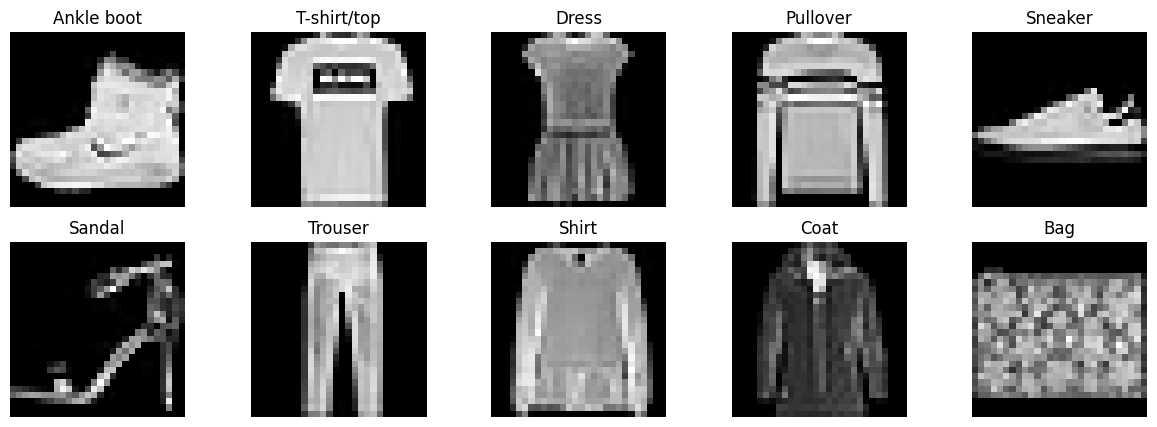

In [ ]:
def plot_sample_image_of_each_class():
    """
    Plots one image of each class in the Fashion MNIST training data using Weights & Biases.
    """

    (X_train, y_train), (_, _) = fashion_mnist.load_data()

    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    labels = []
    images = []

    for i in range(len(X_train)):
        if class_names[y_train[i]] not in labels:
            labels.append(class_names[y_train[i]])
            images.append(np.array(X_train[i]))
            if len(labels) == 10:  # Change 10 to the number of classes in your dataset
                break

    # for plotting the images in google colab
    num_rows = 2
    num_cols = 5

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    for i in range(len(images)):
        row_idx = i // num_cols
        col_idx = i % num_cols

        axes[row_idx, col_idx].axis("off")
        axes[row_idx, col_idx].imshow(images[i], cmap="gray")
        axes[row_idx, col_idx].set_title(labels[i])

    plt.show()

    # for plotting the images in wandb
    # wandb.init(project="DL_Assignment_1")
    # for img, caption in zip(images, labels):
    #     plot = wandb.Image(img, caption=caption)
    #     wandb.log({"Sample image for each class": plot})

    # wandb.finish()

plot_sample_image_of_each_class()

##Question 2 & Question 3

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k = len(class_names)

# loading the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#flattening the images, originally images is of size 28x28, converting it to 784x1
X_train  = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_train = np.array(X_train)/255.0 # normalizing the input data

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = np.array(X_test)/255.0  # normalizing the input data

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
def initialize_Wandb(neurons_per_layer, method):
    """
        initializes weights and bias by the given method of initialization
    """

    W = []
    b = []
    np.random.seed(42)

    for l in range(len(neurons_per_layer)-1):
        if method == "random_uniform":
            W.append(np.random.uniform(-0.7, 0.7, (neurons_per_layer[l+1], neurons_per_layer[l])))
            b.append(np.random.uniform(-0.7, 0.7, (neurons_per_layer[l+1],1)))
        elif method == "xavier":
            W.append(np.random.randn(neurons_per_layer[l+1],neurons_per_layer[l])*np.sqrt(6/(neurons_per_layer[l+1]+neurons_per_layer[l])))
            b.append(np.zeros((neurons_per_layer[l+1], 1)))
        else:
            W.append(np.random.randn(neurons_per_layer[l+1], neurons_per_layer[l]) * 0.001)
            b.append((np.random.randn(neurons_per_layer[l+1],1)) * 0.001)

    return W, b

In [ ]:
# activation func and their derivatives

def sigmoid(x):
    return 1.0/(1.+np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1 - np.tanh(x)**2


def identity(x):
    return x


def identity_derivative(x):
    return 1

In [ ]:
# loss functions

def cross_entropy(y, y_hat, W, weight_decay):
    loss = 0
    for i in range(len(y)):
        for j in range(len(y[i])):
            loss += -1.0 * y[i][j] * np.log(y_hat[i][j])

    reg = 0
    for i in range(len(W)):
        reg += np.sum(np.square(W[i]))

    regularized_loss = loss + weight_decay * reg
    return regularized_loss


def mean_square_error(y, y_hat, W, weight_decay):
    loss = 0.5 * np.sum(np.square(y-y_hat))
    reg = 0
    for i in range(len(W)):
        reg += np.sum(np.square(W[i]))

    regularized_loss = loss + weight_decay * reg
    return regularized_loss

In [ ]:
# output functions

def softmax(a):
    return np.exp(a)/np.sum(np.exp(a), axis=0)

In [ ]:
# utility functions

def evaluate_model(W, b, X, y, num_hidden_layers, activation_func, weight_decay, loss_func):
    """
        calculates loss and accuracy of the model
    """
    y_hat, activation, preactivation = forward_propogation(W, b, X, num_hidden_layers, activation_func)
    y_pred = []
    for i in range(len(y_hat[0])):
        y_pred.append(np.argmax(y_hat[:,i]))

    acc = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            acc += 1

    acc = (acc * 100) / len(y)

    y_one_hot = generate_one_hot_matrix(len(y), y)

    if loss_func == "cross_entropy":
        loss = cross_entropy(y_one_hot, y_hat, W, weight_decay)
    else:
        loss = mean_square_error(y_one_hot, y_hat, W, weight_decay)

    return acc, loss/len(y)


def generate_one_hot_matrix(batch_size, y):
    '''
        generates one hot matrix, where the ith col gives the one hot vector for the ith image
        and in that vector only the row number of true class will be 1 and rest will be zero
    '''
    y_one_hot = np.zeros((10,batch_size))
    for i in range(batch_size):
        y_one_hot[y[i]][i] = 1
    return y_one_hot


def split_train_val_data(X, y, validation_percent=0.1, random_seed=None):
    """
    Split the data into training and validation sets.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    num_samples = len(X)
    num_val_samples = int(validation_percent * num_samples)

    # Randomly shuffle indices
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Split data based on shuffled indices
    val_indices = indices[:num_val_samples]
    train_indices = indices[num_val_samples:]

    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    return X_train, X_val, y_train, y_val

In [ ]:
def forward_propogation(W, b, X, num_hidden_layers, activation_func):
    """
        does one forward pass of the data with the current weights and biases
    """

    preactivation = []
    activation = []

    preactivation.append(X.T)
    if activation_func == "sigmoid": activation.append(sigmoid(X.T))
    elif activation_func == "ReLU": activation.append(relu(X.T))
    else: activation.append(tanh(X.T))

    for i in range(1, num_hidden_layers+1):
        preactivation.append(np.matmul(W[i-1], activation[(i-1)]) + b[i-1])
        if activation_func == "sigmoid":
            activation.append(sigmoid(preactivation[i]))
        elif activation_func == "ReLU":
            activation.append(relu(preactivation[i]))
        elif activation_func == "tanh":
            activation.append(tanh(preactivation[i]))

    preactivation.append(np.dot(W[-1], activation[-1]) + b[-1])
    activation.append(softmax(preactivation[-1]))
    y_hat = activation[-1]
    return y_hat, activation, preactivation

In [ ]:
def backward_propogation(W, b, y_one_hot, activation, preactivation, L, activation_func, loss_func):
    """
        back_propogation algorithm for updating the parameters
    """

    grad_preactivation = []

    # grad with respect to output units
    if loss_func == "cross_entropy":
        grad_preactivation.append(activation[L]-y_one_hot)
    else:
        grad_preactivation.append(np.multiply((activation[L]-y_one_hot) , -2*np.multiply(activation[L], 1-activation[L])))

    grad_W = []
    grad_b = []

    for i in range(L, 0, -1):
        # grad with respect to weights and biases
        grad_W.append(np.matmul(grad_preactivation[-1], activation[i-1].T))
        grad_b.append(np.sum(grad_preactivation[-1], axis=1, keepdims=True))

        if i == 1:
            break

        # grad with respect to hidden units
        grad_hi = np.matmul(W[i-1].T, grad_preactivation[-1])

        if activation_func == "sigmoid":
            grad_preactivation.append(np.multiply(grad_hi, sigmoid_derivative(preactivation[i-1])))
        elif activation_func == "ReLU":
            grad_preactivation.append(np.multiply(grad_hi, relu_derivative(preactivation[i-1])))
        elif activation_func == "tanh":
            grad_preactivation.append(np.multiply(grad_hi, tanh_derivative(preactivation[i-1])))

    return grad_W[::-1], grad_b[::-1]

In [ ]:
# update rules for various types of gradient descent

def update_parameters(W, grad_W, b, grad_b, eta):
    """
    normal gradient descent
    """
    for i in range(0, len(W)):
        W[i] = W[i] - eta * grad_W[i]
        b[i] = b[i] - eta * grad_b[i]

    return W, b


def update_parameters_mgd(W, grad_W, b, grad_b, eta, beta, W_history, b_history):
    """
    momentum based gradient descent
    """
    for t in range(len(W)):
        W_history[t] = beta * W_history[t] + grad_W[t]
        b_history[t] = beta * b_history[t] + grad_b[t]
    for i in range(len(W)):
        W[i] = W[i] - eta * W_history[i]
        b[i] = b[i] - eta * b_history[i]

    return W, b, W_history, b_history


def update_parameters_nag(W, W_history, b, b_history, eta, beta):
    """
        nesterov accelerated gradient descent
    """
    for i in range(len(W)):
        W_history[i] = beta * W_history[i]
        b_history[i] = beta * b_history[i]

    for i in range(len(W)):
        W[i] = W[i] - eta * W_history[i]
        b[i] = b[i] - eta * b_history[i]

    return W, b, W_history, b_history


def update_parameters_rmsprop(W, grad_W, b, grad_b, vt_W, vt_b, eta, beta, epsilon):
    """
        rmsprop gradient descent
    """
    for i in range(len(grad_W)):
        vt_W[i] = beta * vt_W[i] + (1 - beta) * np.square(grad_W[i])
        vt_b[i] = beta * vt_b[i] + (1 - beta) * np.square(grad_b[i])

    for i in range(len(W)):
        W[i] = W[i] - (eta/np.sqrt(vt_W[i]+epsilon)) * grad_W[i]
        b[i] = b[i] - (eta/np.sqrt(vt_b[i]+epsilon)) * grad_b[i]

    return W, b, vt_W, vt_b


def update_parameters_adam(W, grad_W, vt_W, mt_W, b, grad_b, vt_b, mt_b, t, eta, beta1, beta2, epsilon):
    for i in range(len(W)):
        curr_mt_W = beta1 * mt_W[i] + (1 - beta1) * grad_W[i]
        curr_mt_b = beta1 * mt_b[i] + (1 - beta1) * grad_b[i]

        curr_vt_W = beta2 * vt_W[i] + (1 - beta2) * np.square(grad_W[i])
        curr_vt_b = beta2 * vt_b[i] + (1 - beta2) * np.square(grad_b[i])

        mt_W_hat = curr_mt_W / (1.0 - beta1**t)
        mt_b_hat = curr_mt_b / (1.0 - beta1**t)

        vt_W_hat = curr_vt_W / (1.0 - beta2**t)
        vt_b_hat = curr_vt_b / (1.0 - beta2**t)

        # saving for the next iteration
        mt_W[i] = curr_mt_W
        mt_b[i] = curr_mt_b
        vt_W[i] = curr_vt_W
        vt_b[i] = curr_vt_b

        # updating the parameters
        W[i] = W[i] - (eta/(np.sqrt(vt_W_hat) + epsilon)) * mt_W_hat
        b[i] = b[i] - (eta/(np.sqrt(vt_b_hat) + epsilon)) * mt_b_hat

    return W, b, vt_W, vt_b, mt_W, mt_b


def update_parameters_nadam(W, grad_W, vt_W, mt_W, b, grad_b, vt_b, mt_b, t, eta, beta1, beta2, epsilon):
    for i in range(len(W)):
        curr_mt_W = beta1 * mt_W[i] + (1 - beta1) * grad_W[i]
        curr_mt_b = beta1 * mt_b[i] + (1 - beta1) * grad_b[i]

        curr_vt_W = beta2 * vt_W[i] + (1 - beta2) * np.square(grad_W[i])
        curr_vt_b = beta2 * vt_b[i] + (1 - beta2) * np.square(grad_b[i])

        mt_W_hat = curr_mt_W / (1.0 - beta1**t)
        mt_b_hat = curr_mt_b / (1.0 - beta1**t)

        vt_W_hat = curr_vt_W / (1.0 - beta2**t)
        vt_b_hat = curr_vt_b / (1.0 - beta2**t)

        # saving for the next iteration
        mt_W[i] = curr_mt_W
        mt_b[i] = curr_mt_b
        vt_W[i] = curr_vt_W
        vt_b[i] = curr_vt_b

        # updating the parameters
        W[i] = W[i] - (eta/(np.sqrt(vt_W_hat) + epsilon)) * ((1-beta1)*grad_W[i]/(1-beta1**t))
        b[i] = b[i] - (eta/(np.sqrt(vt_b_hat) + epsilon)) * ((1-beta1)*grad_b[i]/(1-beta1**t))

    return W, b, vt_W, vt_b, mt_W, mt_b

In [ ]:
ce_loss = []
ce_acc = []
mse_loss = []
mse_acc = []

In [ ]:
def gradient_descent(X_train, X_val, y_train, y_val, config):
    # # setting hyper parameters
    num_hidden_layers = config.num_hidden_layers
    size_of_hidden_layer = config.size_of_hidden_layer
    activation_func = config.activation_func
    loss_func = "cross_entropy"
    method = config.method
    num_images = len(X_train)
    batch_size = config.batch_size
    epoch = config.epochs
    eta = config.eta
    weight_decay = config.weight_decay
    optimizer = config.optimizer

    # setting batch_size = 1 for sgd
    if optimizer == "sgd":
        batch_size = 1

    # used for momentum
    beta = 0.5
    W_history = [0] * (num_hidden_layers+1)
    b_history = [0] * (num_hidden_layers+1)

    # used for rmsprop
    vt_W = [0] * (num_hidden_layers+1)
    vt_b = [0] * (num_hidden_layers+1)
    epsilon = 1e-8
    beta = 0.5

    # usef for adam and nadam
    vt_W = [0] * (num_hidden_layers+1)
    vt_b = [0] * (num_hidden_layers+1)
    mt_W = [0] * (num_hidden_layers+1)
    mt_b = [0] * (num_hidden_layers+1)
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 1

    run_name = f"opt_{optimizer}_act_{activation_func}_ep_{epoch}_eta_{eta}_L_{num_hidden_layers}_hs_{size_of_hidden_layer}_bs_{batch_size}_mthd_{method}_wd_{weight_decay}"
    y_pred = []

    # making the list of structure of neural networks
    neurons_per_layer = [X_train.shape[1]]
    for i in range(num_hidden_layers):
        neurons_per_layer.append(size_of_hidden_layer)
    neurons_per_layer.append(k)


    # Initialize W, b
    W, b = initialize_Wandb(neurons_per_layer, method)

    y_hat = []
    for iteration in tqdm(range(epoch)):
        for i in range(0, num_images, batch_size):
            if i + batch_size > num_images:
                X_batch = X_train[i:]
                y_batch = y_train[i:]
                batch_size = len(X_batch)
            else:
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

            if optimizer == "momentum":
                hL, activation, preactivation = forward_propogation(W, b, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W, b, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b, W_history, b_history = update_parameters_mgd(W, grad_W, b, grad_b, eta, beta, W_history, b_history)
            elif optimizer == "nag":
                W_look_ahead, b_look_ahead, W_history, b_history = update_parameters_nag(W, W_history, b, b_history, eta, beta) # updating by history
                hL, activation, preactivation = forward_propogation(W_look_ahead, b_look_ahead, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W_look_ahead, b_look_ahead, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b = update_parameters(W, grad_W, b, grad_b, eta) # updating by the grad of lookahead point
            elif optimizer == "rmsprop":
                hL, activation, preactivation = forward_propogation(W, b, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W, b, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b, vt_W, vt_b = update_parameters_rmsprop(W, grad_W, b, grad_b, vt_W, vt_b, eta, beta, epsilon)
            elif optimizer == "adam":
                hL, activation, preactivation = forward_propogation(W, b, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W, b, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b, vt_W, vt_b, mt_W, mt_b = update_parameters_adam(W, grad_W, vt_W, mt_W, b, grad_b, vt_b, mt_b, t, eta, beta1, beta2, epsilon)
                t += 1
            elif optimizer == "nadam":
                W_look_ahead, b_look_ahead, vt_W, vt_b = update_parameters_nag(W, W_history, b, b_history, eta, beta) # updating by history
                hL, activation, preactivation = forward_propogation(W_look_ahead, b_look_ahead, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W, b, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b, vt_W, vt_b, mt_W, mt_b = update_parameters_nadam(W, grad_W, vt_W, mt_W, b, grad_b, vt_b, mt_b, t, eta, beta1, beta2, epsilon)
                t += 1
            else:
                # this else block is for sgd
                hL, activation, preactivation = forward_propogation(W, b, X_batch, num_hidden_layers, activation_func)
                y_one_hot = generate_one_hot_matrix(batch_size, y_batch)
                grad_W, grad_b = backward_propogation(W, b, y_one_hot, activation, preactivation, num_hidden_layers+1, activation_func, loss_func)
                W, b = update_parameters(W, grad_W, b, grad_b, eta)


        val_accuracy, val_loss = evaluate_model(W, b, X_val, y_val, num_hidden_layers, activation_func, weight_decay, loss_func)
        train_accuracy, train_loss = evaluate_model(W, b, X_train, y_train, num_hidden_layers, activation_func, weight_decay, loss_func)
        print(f" val_accuracy:{val_accuracy}, val_loss:{val_loss}, train_accuracy:{train_accuracy}, train_loss:{train_loss}")
        wandb.log({"val_accuracy":val_accuracy, 'val_loss':val_loss, "train_accuracy":train_accuracy, "train_loss":train_loss, "epoch":iteration+1})

        # saving val_accuracy and val_loss for comparing 2 loss func
        if loss_func == "cross_entropy":
            ce_acc.append(val_accuracy)
            ce_loss.append(val_loss)
        else :
            mse_acc.append(val_accuracy)
            mse_loss.append(val_loss)

    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

## Question 4 , Question 5 and Question 6

In [ ]:
X_train, X_val, y_train, y_val = split_train_val_data(X_train, y_train)

sweep_config = {
"name": "Cross Entropy Loss",
"metric": {
    "name":"val_accuracy",
    "goal": "maximize"
},
"method": "bayes",
"parameters": {
        "eta": {
            "values": [1e-3, 1e-4]
        },
        "activation_func": {
            "values": ["sigmoid", "tanh", "ReLU"]
        },
        "method": {
            "values": ["xavier", "random_uniform", "random_normal"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]
        },
        "batch_size": {
            "values": [16,32]
        },
        "epochs": {
            "values": [5, 10]
        },
        "weight_decay": {
            "values": [0, 0.0005, 0.05]
        },
        "size_of_hidden_layer": {
            "values": [32, 64, 128]
        },
        "num_hidden_layers": {
            "values": [3, 4, 5]
        }
    }
}

def train():
    with wandb.init(project="DL_Assignment_1") as run:
        config = wandb.config
        gradient_descent(X_train, X_val, y_train, y_val, config)

sweep_id = wandb.sweep(sweep_config, project = "DL_Assignment_1")
wandb.agent(sweep_id, train, count = 3)
wandb.finish()

## Question 7

In [ ]:
def plot_confusion_matrix(y_pred, y_test):
    wandb.log({"confusion_matrix" : wandb.plot.confusion_matrix(y_true=y_test, preds=y_pred, class_names=None)})
    wandb.finish()

In [ ]:
def calc_test_accuracy(X_test, y_test, W, b, num_hidden_layers, activation_func):
    hL, activation, preactivation = forward_propogation(W, b, X_test, num_hidden_layers, activation_func)
    y_pred = []
    for i in range(len(hL[0])):
        y_pred.append(np.argmax(hL[:, i]))

    count = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            count += 1

    return count * 100 / len(y_test)

## Question 8
For plotting run the model once with loss func "cross_entropy" and once with "mean_squared_error"

In [ ]:
# plotting loss

x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x, ce_loss, label="cross_entropy_loss")
plt.plot(x, mse_loss, label="mean_square_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("loss.jpg")

In [ ]:
# plotting accuracy

x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x, ce_acc, label="cross_entropy")
plt.plot(x, mse_acc, label="mean_square_error")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("acc.jpg")